# Laboratorio di simulazione numerica

In [13]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import math
import string
from mpl_toolkits.mplot3d import Axes3D

#### Exercise 05.1

In this exercise I sampled the probability distribution of the position of an electron in the ground state of a hydrogen atom, using the Metropolis algorithm.
I used a uniform transition probability, in a cube of edge 1.2 Bohr radii. The acceptance ratio was 0.50556, after 100 000 steps.
The following plot shows the distribution in space of the sampled points.

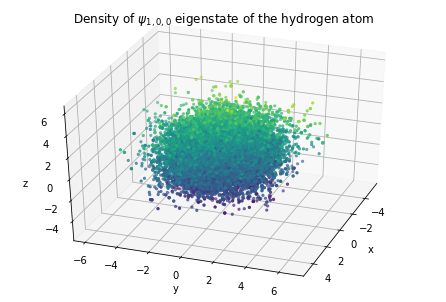

In [10]:
x, y, z = np.loadtxt("sampled_points_uniform.dat", unpack = True)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title(r"Density of $\psi_{1,0,0}$ eigenstate of the hydrogen atom")
ax.view_init(35, 20)
plt.show()

The following plot shows the progressive value of the average radius, and its standard deviation, of the above results, using a blocking technique dividing the data in 100 blocks.

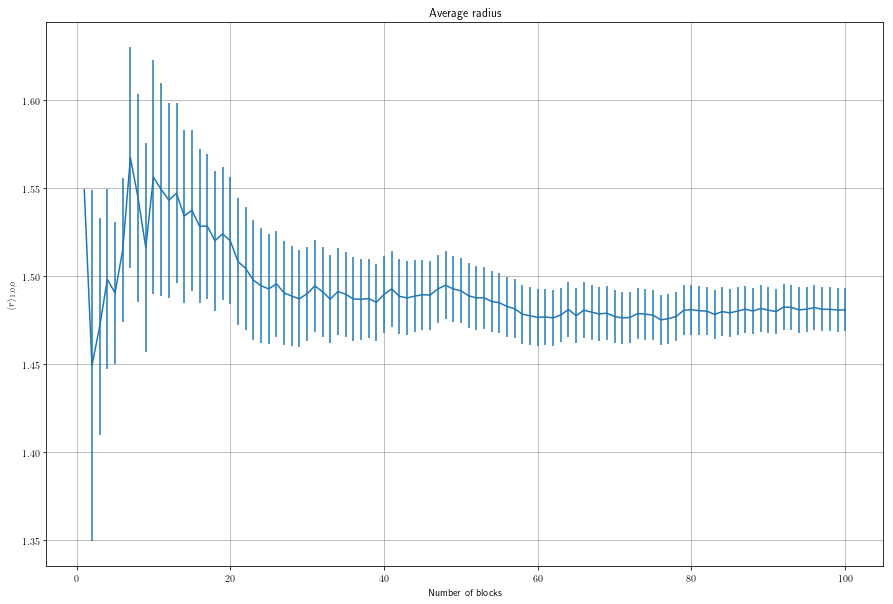

In [16]:
radius_avg, radius_std = np.loadtxt("radius_avg_uniform.dat", unpack = True)

plt.figure(1, figsize = (15,10))
plt.errorbar(range(1, len(radius_avg) + 1), radius_avg, yerr = radius_std)
plt.title("Average radius")
plt.ylabel(r"$\langle r\rangle_{1,0,0}$")
plt.xlabel("Number of blocks")
plt.grid(True)